# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

2024-07-15 13:47:21.385777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 13:47:21.399967: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 13:47:21.501684: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 13:47:21.616215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 13:47:21.720038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

/tmp/ipykernel_607619/13106036.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


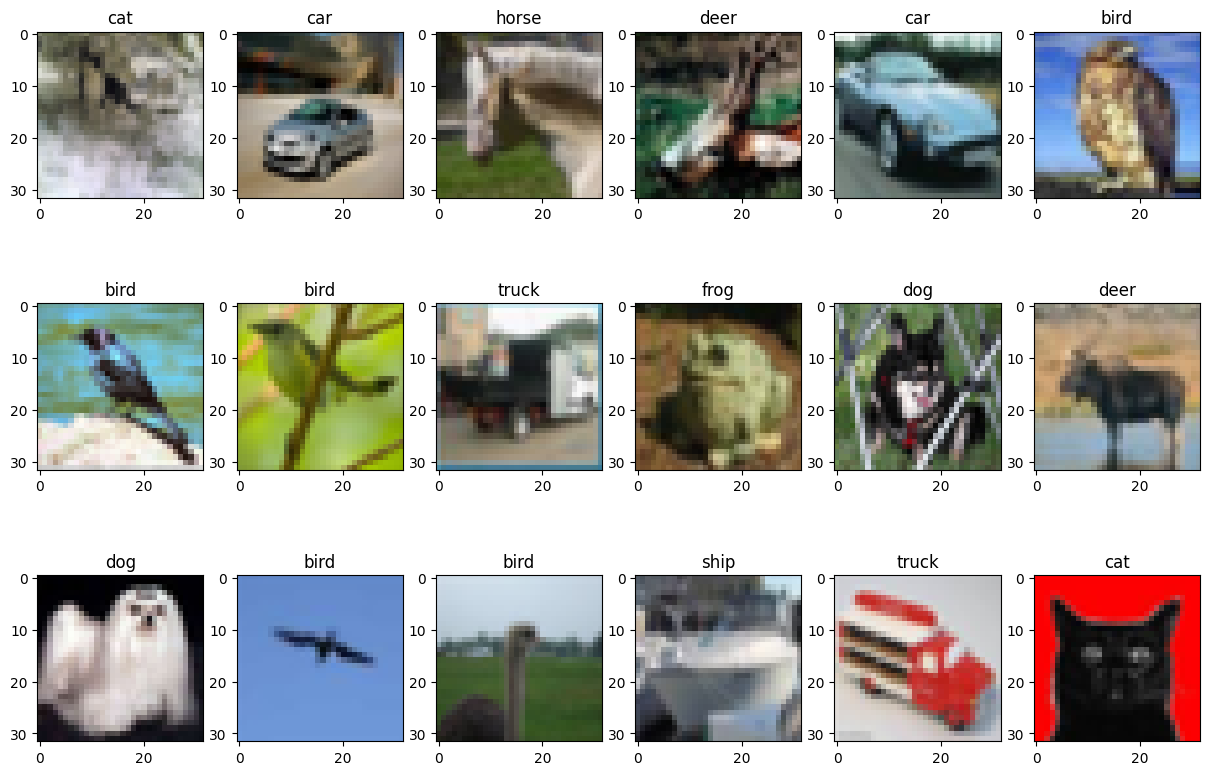

In [46]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(len(x_test))
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

In [6]:
from collections import Counter

# Compute the class histogram
y_train_flat = y_train.flatten()
class_counts = Counter(y_train_flat)

print(y_train_flat)
print(class_counts)

[6 9 9 ... 9 1 1]
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


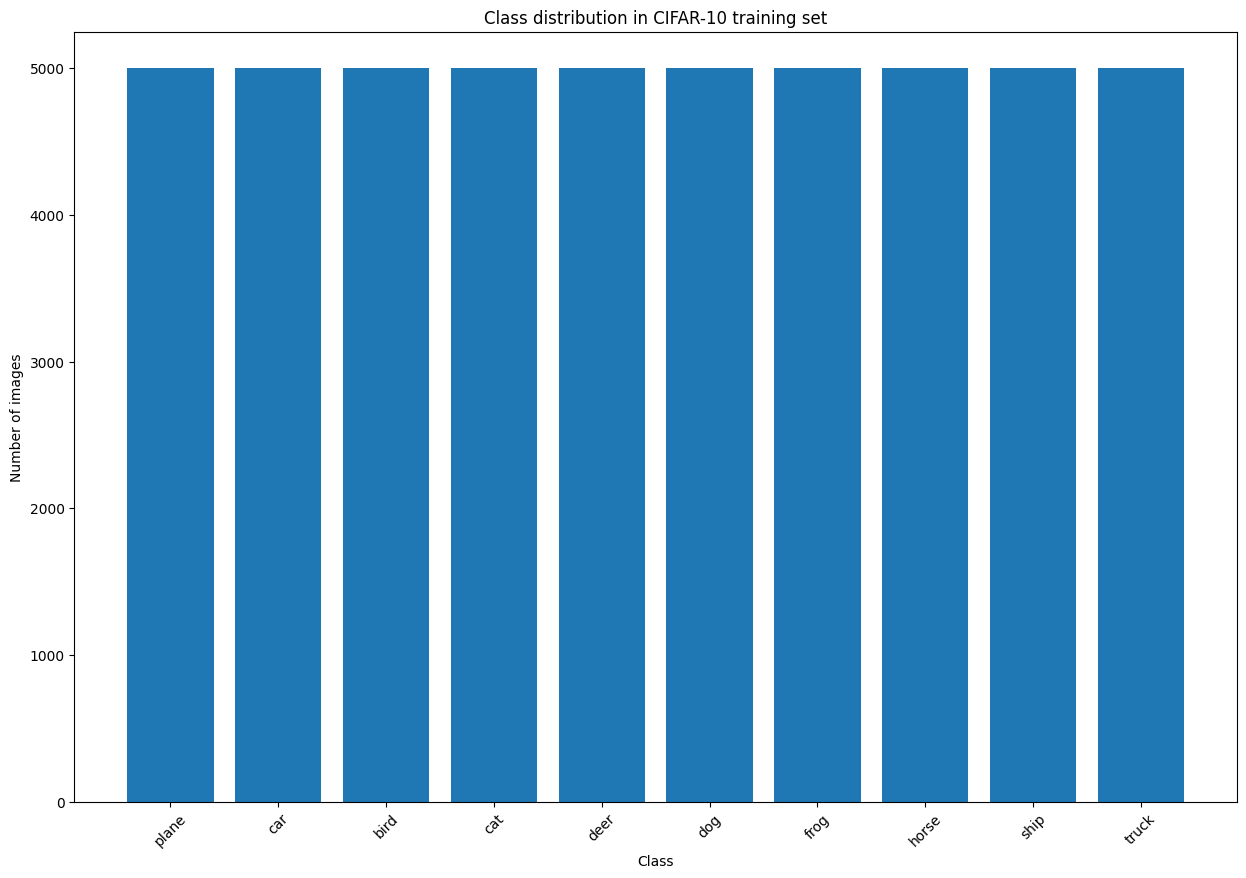

Is the dataset balanced? Yes


In [7]:
# Visualize the class histogram
fig, ax = plt.subplots()
ax.bar(classes.values(), class_counts.values())
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Class distribution in CIFAR-10 training set')
plt.xticks(rotation=45)
plt.show()

# Check if the dataset is balanced
balanced = all(count == class_counts[0] for count in class_counts.values())
print(f"Is the dataset balanced? {'Yes' if balanced else 'No'}")

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [8]:
from keras.src.utils import to_categorical

# Normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [39]:
from tensorflow.keras.layers import BatchNormalization, Dropout

# Build the classifier
inputs = Input(shape=(size, size, 3))

net = Conv2D(64, kernel_size=(3, 3), activation="relu")(inputs)
net = BatchNormalization()(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)

net = Conv2D(128, kernel_size=(3, 3), activation="relu")(net)
net = BatchNormalization()(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)

net = Conv2D(256, kernel_size=(3, 3), activation="relu")(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)

net = Flatten()(net)
net = Dense(512, activation="relu")(net)
net = BatchNormalization()(net)
net = Dropout(0.5)(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)

# Show the model
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,882 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Step 3: Training

Compile the model and train it.

In [40]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.callbacks import early_stopping, EarlyStopping, ReduceLROnPlateau

epochs = 25
batch_size = 32

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


# Train the model
start = time()
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)
print('Elapsed time', time() - start)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 40ms/step - accuracy: 0.2561 - loss: 2.3626 - val_accuracy: 0.3992 - val_loss: 1.7375 - learning_rate: 0.0010
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.4735 - loss: 1.4716 - val_accuracy: 0.5440 - val_loss: 1.2726 - learning_rate: 0.0010
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.5568 - loss: 1.2467 - val_accuracy: 0.6031 - val_loss: 1.1618 - learning_rate: 0.0010
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.6056 - loss: 1.1307 - val_accuracy: 0.6346 - val_loss: 1.0415 - learning_rate: 0.0010
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.6383 - loss: 1.0472 - val_accuracy: 0.7070 - val_loss: 0.8437 - learning_rate: 0.0010
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.6591 - loss: 0.9809 - val_accuracy: 0.6725 - val_loss: 0.9981 - learning_rate: 0.0010
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accura

Train Acc      0.7780600190162659
Validation Acc 0.7599999904632568


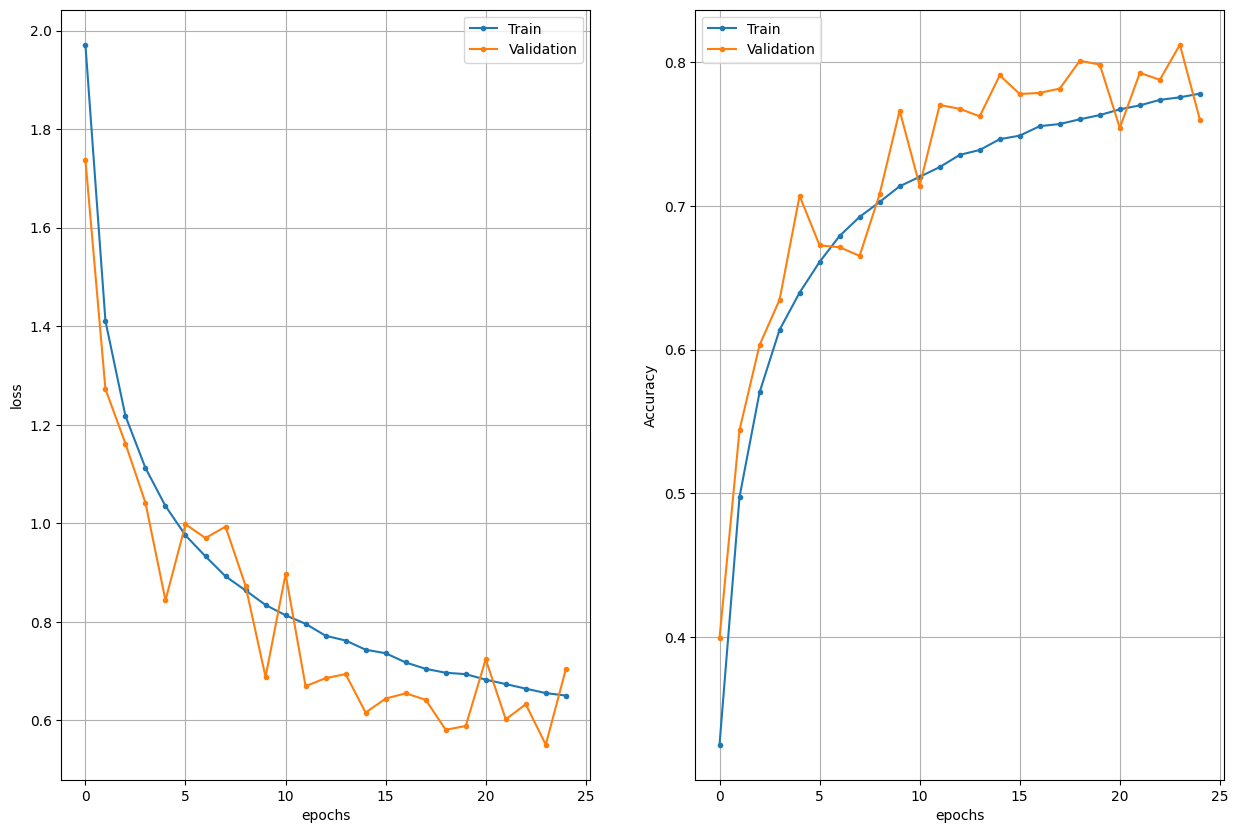

In [41]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [42]:
# Compute the labels and the predictions as sparse values
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [43]:
# Compute and print the accuracy for each class
class_accuracy = {}
for class_id, class_name in classes.items():
    class_indices = np.where(y_true == class_id)[0]
    class_correct_indices = np.where(y_pred[class_indices] == class_id)[0]
    acc = len(class_correct_indices) / len(class_indices) if len(class_indices) > 0 else 0.0
    class_accuracy[class_name] = acc
    print(f'{class_name}: {acc:.2f}')


plane: 0.79
car: 0.91
bird: 0.64
cat: 0.63
deer: 0.85
dog: 0.68
frog: 0.95
horse: 0.88
ship: 0.89
truck: 0.91


In [44]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8141 - loss: 0.5464
Test loss   0.5506163835525513
Test metric 0.8120999932289124


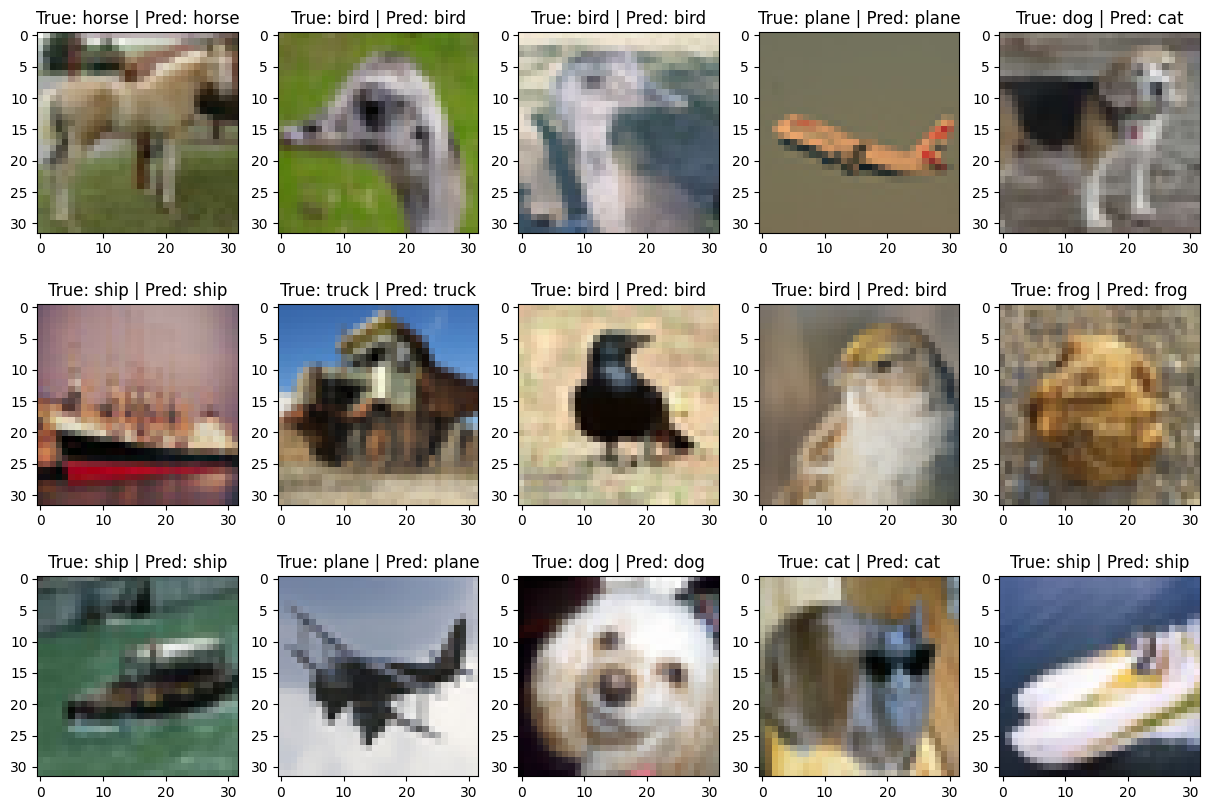

In [45]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(len(x_test))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?
* Train Acc      0.7780600190162659
* Validation Acc 0.7599999904632568
* 

* What modifications would you do in order to improve the classification accuracy?
* Использование предобученных моделей
* Увеличение размера и сложности модели
* Увеличение количества эпох обучения:
* Регуляризация:
* Аугментация данных:
* 

* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?
* После добавления слоев, дропаута, early_stopping улучшыть сеть не получилось,  точность уменьшилась с 85% до 75% 